___

**project**: `Mental Health Conversation Bot (MHCB)`

**date**: `2022-12-14`

**decription**: `This notebook represent the code for data preparation all the way to model traing of an AI chatbot that will behave and chat with human like a therapist.`

**main**: `Natural Language Processing (NLP) pytorch`

**programmer**: `crispengari`

**architecture**: `BiDirectional Long Short Term Memory [BiLSTM] (torchtext)`

**language:** `python`

____


### Problem Statement
"The world have been facing problem in shortage of labour, using chatbots intergated with modern deep learning in the field of artificial intelligence, bots can be created and behave like humans."

In this project I will create a chatbot that will behave and converate with people like a therapist.

### Data
The dataset that we going to use in this notebook we be comming from [kaggle](https://www.kaggle.com/datasets/elvis23/mental-health-conversational-data). We are going to generate our dataset based on the file called `intents.json` which is a file that contains `80` intents. We are going to save the prepared data into `.csv` files for three sets which are:

1. train
2. test
3. validation


### Model Architecture
We are going to use `BiLSTM` in doing `multi-class` classifications of intents for our `Bot`. We are going to use the following notebook as reference:

> [03_BiLSTM_CUSTOM_EMBEDDING_VECTORS](https://github.com/CrispenGari/torchtext/blob/main/sentiment-analyisis/03_BiLSTM_CUSTOM_EMBEDDING_VECTORS.ipynb)

### Installing Helper Packages
In the following code cell we are going to install the package called `helperfns` that provide us with some usefull helper functions for machine learning.

In [ ]:
pip install helperfns -q

#### Imports

In  the following code cell we are going to import all the packages that we are going to use throughout this `notebook`

In [ ]:
import time
import json
import torch
import os
import random
import torchtext
from matplotlib import pyplot as plt
from torch import nn
from torchtext import data
from collections import Counter
from torchtext import vocab

from helperfns.tables import tabulate_data
from helperfns.visualization import plot_complicated_confusion_matrix, plot_simple_confusion_matrix
from helperfns.utils import hms_string

import torch.nn.functional as F
import numpy as np
import pandas as pd

from google.colab import drive, files

torchtext.__version__, torch.__version__

/usr/local/lib/python3.10/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated

('0.18.0+cpu', '2.3.0+cu121')

### Seed
In the following code cell we are going to set the seed to all random operations for reproducivity.

In [ ]:
SEED = 42

random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True

### Device
In the following code cell we are going to get `gpu` device if possible

In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Data

Our dataset that we are going to use will be comming from [`kaggle`](https://www.kaggle.com/datasets/elvis23/mental-health-conversational-data) and will be loaded from google drive  where i uploaded it in a folder called `MHCB`. So in the following code cell we are going to mount our google drive to this colab instance.

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


### Path to the dataset.
Now we can define the path as a variable to the location where our `intents.json` file is located in the following codecell.

In [ ]:
base_dir = "/content/drive/My Drive/NLP Data/MHCB"

assert os.path.exists(base_dir), f"The path '{base_dir}' does not exists."
intents_path = os.path.join(base_dir, 'intents.json')
assert os.path.exists(intents_path), f"The path '{intents_path}' does not exists."

Then we need to read the `intents.json` file and create a classification dataset from it.

In [ ]:
with open(intents_path, "r") as f:
  intents_data = json.load(f)

An example of as single intent in that file looks as follows:

```json
{
"tag": "greeting",
"patterns": [
  "Hi",
  "Hey",
  "Is anyone there?",
  "Hi there",
  "Hello",
  "Hey there",
  "Howdy",
  "Hola",
  "Bonjour",
  "Konnichiwa",
  "Guten tag",
  "Ola"
],
"responses": [
  "Hello there. Tell me how are you feeling today?",
  "Hi there. What brings you here today?",
  "Hi there. How are you feeling today?",
  "Great to see you. How do you feel currently?",
  "Hello there. Glad to see you're back. What's going on in your world right now?"
]
},
```
So what we are intrested in for model training is `patterns` and it's tag, so our target value that we are trying to predict is a `tag` given a certain `pattern`. So from this we are going to generate our data maped with all the `pattens` to their labels.

In [ ]:
dataset = list()
for intent in intents_data.get('intents'):
  label = intent.get('tag').lower()
  for pattern in intent.get('patterns'):
    feature = pattern.lower()
    dataset.append((feature, label))

print("Dataset size: {}".format(len(dataset)))

Dataset size: 232


We have a small dataset that contains `232` examples, let's check the first `10` examples in the dataset:

In [ ]:
dataset[:10]

[('hi', 'greeting'),
 ('hey', 'greeting'),
 ('is anyone there?', 'greeting'),
 ('hi there', 'greeting'),
 ('hello', 'greeting'),
 ('hey there', 'greeting'),
 ('howdy', 'greeting'),
 ('hola', 'greeting'),
 ('bonjour', 'greeting'),
 ('konnichiwa', 'greeting')]

Next we are going to use the `random` module to shuffle our dataset and then check again the size first `10` examples before creating dataframes.

In [ ]:
random.shuffle(dataset)

In [ ]:
dataset[:10]

[('financial problems', 'default'),
 ('that sounds awful. what do i do?', 'scared'),
 ('konnichiwa', 'greeting'),
 ('boyfriend', 'default'),
 ('support me please', 'help'),
 ('wrong response', 'wrong'),
 ("i'm scared", 'scared'),
 ('i feel ok', 'happy'),
 ('define depression', 'fact-3'),
 ('what does it mean to have a mental illness?', 'fact-8')]

So for our train data we are going to take all the examples in the `dataset` and then for the `validation` and `testing` set we are going to take a fraction of `40%` and `60%` from the dataset respectively.

In [ ]:
train_df = pd.DataFrame(dataset, columns=["text", "label" ])
TEST_EXAMPLES = int(.6 * len(dataset))

random.shuffle(dataset)
test_df = pd.DataFrame(dataset[:TEST_EXAMPLES], columns=["text", "label" ])
val_df = pd.DataFrame(dataset[TEST_EXAMPLES: ], columns=["text", "label" ])

array(['default', 'scared', 'greeting', 'help', 'wrong', 'happy',
       'fact-3', 'fact-8', 'problem', 'no-response', 'death', 'fact-2',
       'user-advice', 'learn-mental-health', 'understand', 'suicide',
       'fact-23', 'sad', 'stressed', 'fact-27', 'done', 'casual',
       'fact-6', 'worthless', 'goodbye', 'hate-me', 'morning', 'name',
       'depressed', 'thanks', 'hate-you', 'fact-26', 'neutral-response',
       'creation', 'fact-10', 'fact-9', 'about', 'sleep', 'night',
       'fact-20', 'learn-more', 'stupid', 'fact-17', 'jokes', 'location',
       'afternoon', 'no-approach', 'fact-21', 'pandora-useful', 'repeat',
       'fact-5', 'fact-29', 'fact-7', 'not-talking', 'user-agree',
       'fact-1', 'something-else', 'fact-11', 'fact-32', 'fact-13',
       'friends', 'meditation', 'fact-18', 'evening', 'user-meditation',
       'fact-28', 'anxious', 'fact-14', 'fact-24', 'fact-12', 'fact-16',
       'fact-25', 'fact-15', 'skill', 'fact-19', 'fact-22', 'ask',
       'fact-31', '

Checking our dataframes.


1. train dataframe

In [ ]:
train_df.head(5)

,text,label
0,financial problems,default
1,that sounds awful. what do i do?,scared
2,konnichiwa,greeting
3,boyfriend,default
4,support me please,help


2. test dataframe

In [ ]:
test_df.head(5)

,text,label
0,nothing much,neutral-response
1,what's your name?,about
2,i am happy.,happy
3,how can i find a mental health professional fo...,fact-14
4,not really,no-approach


3. validatation dataframe

In [ ]:
val_df.head(5)

,text,label
0,tell me another fact about mental health,mental-health-fact
1,my brother died,death
2,nothing else,done
3,what are the different types of mental health ...,fact-23
4,i don't like you,hate-you


Now that we have text matched to labels, we can go ahead and save the `csv` files for these 3 different sets of data

In [ ]:
train_df.to_csv(os.path.join(base_dir, "train.csv"),  index = False, header = True)
test_df.to_csv(os.path.join(base_dir, "test.csv"),  index = False, header = True)
val_df.to_csv(os.path.join(base_dir, "val.csv"),  index = False, header = True)
print("Done")

Done


In the following code cell we are going to count the examples that are in each set of our whole dataset.

In [ ]:
columns = ["Set", "Example(s)"]

examples = [
    ['training', len(train_df)],
    ['validation', len(val_df)],
    ['testing', len(test_df)],
    ['total', len(train_df) +  len(test_df) + len(val_df)],
]

tabulate_data(columns, examples, "Exmples")

Exmples
+------------+------------+
| Set        | Example(s) |
+------------+------------+
| training   |        232 |
| validation |         93 |
| testing    |        139 |
| total      |        464 |
+------------+------------+


### Features and Labels
Our fetures are the actual `text` in the dataframes which is the column named `text` and our labels will come from the column called `label`. In the following code cell we are going to read features and labels in a numpy arrays for each set.

In [ ]:
# train
train_texts = train_df.text.values
train_labels = train_df.label.values

# test
test_texts = test_df.text.values
test_labels = test_df.label.values

# val
val_texts = val_df.text.values
val_labels = val_df.label.values

### Text Preprocessing
In our text processing pipeline we need to do the following steps:

1. tokenize sentences
* this is the process of converting a sentence or text into senquence of word. For this process we are going to use a pre-trained model from spacy language model. You can read more about other tokenizers that you can use at [pytorch](https://pytorch.org/text/stable/data_utils.html).org.

2. vocabulary
We will to create a vocabulary based on our sentences that are in the train dataset. A `vocabulary` is esentially a `word` to `index` mapping that allows us to reference the word with their integer representation, since machine leaning models does not understand words. This vocabulary will be used during model training and also can be used at model inference.

### Tokenizer
In the following code cell we are going to geta a tokenier object that will convert a sentence into a sequence of word using the `spacy-en` language model. The reason we are using the english langauge model it's because our intents are in english.

In [ ]:
tokenizer = data.utils.get_tokenizer('spacy', 'en')
tokenizer("This is a boy.")

/usr/local/lib/python3.10/dist-packages/torchtext/data/utils.py:105: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(


['This', 'is', 'a', 'boy', '.']

### Vocabulary
In the following code cell we are going to create a `vocabulary` object from torchtext. This vocabulary takes in an `` of words to their count. So we are going to use the `Counter` module from `collections` to generate these counts from our train features.

We are going to specify the `min_freq` to `2` meaning that the words that does not appear at least 2 times will be converted to unknown. We are also going to specify the special tokens during creation of the vocabulary object.

In [ ]:
counter = Counter()
for line in train_texts:
    counter.update(tokenizer(line))

#  our special tokens are (unknown, padding, start of sentence, end of sentence)
vocabulary = vocab.vocab(counter, min_freq=2, specials=('[unk]', '[pad]', '[sos]', '[eos]'))

### STOI - String To Integer
This will be a dictionary that contains a string to integer mapping which will be our actual vocabulary. In the following code cell we are going to create object called `stoi` which is essentially a dictionary of word to index mapping. This dictionary will be used during training as well as during model inference.

In [ ]:
stoi = vocabulary.get_stoi()

### Text Pipeline
After our text has been tokenized we need a way of converting those words into numbers because machine leaning models understand numbers not words. That's where we the `text_pipeline` function comes into play. So this function takes in a sentence and tokenize it then converts each word to a number. Note that the word that does not exists in the vocabulay (`stoi`) will be converted to  an unkown `('[unk]')` token (0).

In [ ]:
def text_pipeline(x: str):
  values = list()
  tokens = tokenizer(x.lower()) # convert to lower case.
  for token in tokens:
    try:
      v = stoi[token]
    except KeyError as e:
      v = stoi['[unk]']
    values.append(v)
  return values

### Label pipeline
Our labels for now are just textual. We also need to convert these labels into numbers. This is very simple what we need to do is to get all the uniqe labels and then create a `labels_vocab` which is a label to integer representation. which looks as follows:

```json
{"default": 0,
 "scared": 1,
 "greeting": 2,
 "help": 3,
 "wrong": 4,
 "happy": 5,
 "fact-3": 6,
 "fact-8": 7,
 "problem": 8,
 "no-response": 9,
 "death": 10,
 "fact-2": 11,
 "user-advice": 12,
 "learn-mental-health": 13,
 "understand": 14,
 "suicide": 15,
 "fact-23": 16,
 "sad": 17,
 "stressed": 18,
 "fact-27": 19,
 "done": 20,
 "casual": 21,
 "fact-6": 22,
 "worthless": 23,
 "goodbye": 24,
 "hate-me": 25,
 "morning": 26,
 "name": 27,
 "depressed": 28,
 "thanks": 29,
 "hate-you": 30,
 "fact-26": 31,
 "neutral-response": 32,
 "creation": 33,
 "fact-10": 34,
 "fact-9": 35,
 "about": 36,
 "sleep": 37,
 "night": 38,
 "fact-20": 39,
 "learn-more": 40,
 "stupid": 41,
 "fact-17": 42,
 "jokes": 43,
 "location": 44,
 "afternoon": 45,
 "no-approach": 46,
 "fact-21": 47,
 "pandora-useful": 48,
 "repeat": 49,
 "fact-5": 50,
 "fact-29": 51,
 "fact-7": 52,
 "not-talking": 53,
 "user-agree": 54,
 "fact-1": 55,
 "something-else": 56,
 "fact-11": 57,
 "fact-32": 58,
 "fact-13": 59,
 "friends": 60,
 "meditation": 61,
 "fact-18": 62,
 "evening": 63,
 "user-meditation": 64,
 "fact-28": 65,
 "anxious": 66,
 "fact-14": 67,
 "fact-24": 68,
 "fact-12": 69,
 "fact-16": 70,
 "fact-25": 71,
 "fact-15": 72,
 "skill": 73,
 "fact-19": 74,
 "fact-22": 75,
 "ask": 76,
 "fact-31": 77,
 "fact-30": 78,
 "mental-health-fact": 79}
```

> As you have noticed we have `80` labels which are tags that we need to be able to predict.

The `label_pipeline` function will then takes in the label and then returns us an integer representation of that label.

In [ ]:
labels_dict = {k: v for v, k in enumerate(train_df.label.unique())}

In [ ]:
label_pipeline = lambda x: labels_dict[x]

Now that we have our vocabularies for labels `labels_dict` and  features `stoi` we can then save thes files as they will be used suring model inference. We are going to save these files as `.json` files.

In [ ]:
with open(os.path.join(base_dir, "vocab.json"), 'w') as f:
  f.write(json.dumps(stoi, indent=2))

with open(os.path.join(base_dir, "labels_dict.json"), 'w') as f:
  f.write(json.dumps(labels_dict, indent=2))

print("Saved!!")

Saved!!


### Pretrained vectors
In the following code cell we are going to download the predtrained word vectors. We are going to use the `GloVe.6B.100d`. These are pretrained vectors that were trained with about `~6B` words and have a vector representation of a word in `100` dimension for each word.

In [ ]:
EMBEDDING_DIM = 100
glove_vectors = vocab.GloVe('6B', dim=EMBEDDING_DIM)

.vector_cache/glove.6B.zip: 862MB [02:39, 5.41MB/s]                           
100%|█████████▉| 399999/400000 [00:21<00:00, 18444.62it/s]


### Creating Embedding matrix
Now that we have our glove vectors we need to costomize them so that they fit our use case. We are going to create an embedding matrix that suits the our vocabulary. So essentially this embedding matrix will be the word to vector mapping for all the words that arein our vocabulary.

In [ ]:
VOCAB_SIZE = len(stoi)
EMBEDDING_MATRIX= torch.zeros([VOCAB_SIZE, EMBEDDING_DIM])
for i, word in enumerate(vocabulary.get_itos()):
  EMBEDDING_MATRIX[i] = glove_vectors[word]

In the followig code cell we are going to check the embedding matrix for the word `"the"`.

In [ ]:
EMBEDDING_MATRIX[stoi['the']]

tensor([-0.0382, -0.2449,  0.7281, -0.3996,  0.0832,  0.0440, -0.3914,  0.3344,
        -0.5755,  0.0875,  0.2879, -0.0673,  0.3091, -0.2638, -0.1323, -0.2076,
         0.3340, -0.3385, -0.3174, -0.4834,  0.1464, -0.3730,  0.3458,  0.0520,
         0.4495, -0.4697,  0.0263, -0.5415, -0.1552, -0.1411, -0.0397,  0.2828,
         0.1439,  0.2346, -0.3102,  0.0862,  0.2040,  0.5262,  0.1716, -0.0824,
        -0.7179, -0.4153,  0.2033, -0.1276,  0.4137,  0.5519,  0.5791, -0.3348,
        -0.3656, -0.5486, -0.0629,  0.2658,  0.3020,  0.9977, -0.8048, -3.0243,
         0.0125, -0.3694,  2.2167,  0.7220, -0.2498,  0.9214,  0.0345,  0.4674,
         1.1079, -0.1936, -0.0746,  0.2335, -0.0521, -0.2204,  0.0572, -0.1581,
        -0.3080, -0.4162,  0.3797,  0.1501, -0.5321, -0.2055, -1.2526,  0.0716,
         0.7056,  0.4974, -0.4206,  0.2615, -1.5380, -0.3022, -0.0734, -0.2831,
         0.3710, -0.2522,  0.0162, -0.0171, -0.3898,  0.8742, -0.7257, -0.5106,
        -0.5203, -0.1459,  0.8278,  0.27

### Creating Dataset for Training

In the following code cell we are going to create a dataset class called `MHCBataset`. This dataset will takes in the labels and the text of a set.

In [ ]:
class MHCBataset(torch.utils.data.Dataset):
  def __init__(self, labels, text):
    super(MHCBataset, self).__init__()
    self.labels = labels
    self.text = text

  def __getitem__(self, index):
    return self.labels[index], self.text[index]

  def __len__(self):
    return len(self.labels)

### collate_fn
We are going to create a collate function called `tokenize_batch`. This function actually takes in a `batch` and does the preprocessing of the text and labels. This function will be passed to the `DataLoader` class to do the preprocessing of features and labels.

`tokenize_batch` function:

* this function takes in a batch in each set and convert the features and labels to integer representation. It goes ahead and `pad` and `truncate` the sequence to the same `length` and returns `labels` and `features`.

In [ ]:
def tokenize_batch(batch, max_len=100, padding="pre"):
  assert padding=="pre" or padding=="post", "the padding can be either pre or post"
  labels_list, text_list = [], []
  for _label, _text in batch:
    labels_list.append(label_pipeline(_label))
    text_holder = torch.zeros(max_len, dtype=torch.int32)
    processed_text = torch.tensor(text_pipeline(_text.lower()), dtype=torch.int32)
    pos = min(max_len, len(processed_text))
    if padding == "pre":
      text_holder[:pos] = processed_text[:pos]
    else:
      text_holder[-pos:] = processed_text[-pos:]
    text_list.append(text_holder.unsqueeze(dim=0))
  #  the labels will be torch long tensors since it is a multi-class classification.
  return torch.LongTensor(labels_list), torch.cat(text_list, dim=0)

### Datasets
In the following code cell we are going to create the datasets for all our three sets using the `MHCBataset` class.

In [ ]:
train_dataset = MHCBataset(train_labels, train_texts)
test_dataset = MHCBataset(test_labels, test_texts)
val_dataset = MHCBataset(val_labels, val_texts)

### Iterators
In the following code cell we are going to create loaders using the `DataLoader` class from `torch.utils.data` for our `3` sets. We are going to use the `batch_size` of `128` and our `collate_function` is `tokenize_batch`. For the validation and testing dataset we are going to set the shuffle to `False` because there's no need fo us to shuffle these examples.

In [ ]:
BATCH_SIZE = 128
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=tokenize_batch)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=tokenize_batch)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=tokenize_batch)

Checking a single Batch Data

In [ ]:
lbl, txt = next(iter(train_loader))

Labels in the first batch.

In [ ]:
lbl

tensor([23, 15, 32, 28, 50, 15, 17, 20,  4,  3, 45, 29,  3,  2, 36, 17, 46, 64,
         5, 21, 50, 36, 75, 24,  3, 21,  5, 67,  7, 17, 14, 24, 41,  2, 18,  2,
        10, 12, 68, 70, 20, 14, 55,  4, 18, 66, 35,  2, 20, 14,  2, 29, 36, 10,
        53, 73,  6, 36,  0,  0, 21, 22, 36, 17, 24, 37, 15,  2, 13, 62, 64, 20,
        49, 26, 79,  1, 21,  2,  9, 65, 49, 19, 37, 50,  4, 34, 16, 24, 43,  2,
        44, 53,  5, 13, 46, 21, 31, 21, 56, 21, 44, 55,  5, 10, 61, 10, 58, 33,
        15,  4, 30, 53, 40,  3, 29,  8, 17, 61,  2, 17, 57,  5, 28, 25, 42, 14,
         2,  0])

The first sentence in the batch.

In [ ]:
txt[0]

tensor([ 10,  98,  46,   9, 133,   7,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0], dtype=torch.int32)

### Model Creation
Now that we have our loaders we can now create a model. The model that we are going to create is called `MHCBModel`.  As mentioned we are going to use `BiDirectional Long Short Term Memory (BiLSTM)` to build this model.

In [ ]:
class MHCBModel(nn.Module):
  def __init__(self, vocab_size, embedding_size, hidden_size, output_size, num_layers
               , bidirectional, dropout, pad_idx):
    super(MHCBModel, self).__init__()

    self.embedding = nn.Sequential(
        nn.Embedding(vocab_size, embedding_dim=embedding_size, padding_idx=pad_idx),
        nn.Dropout(dropout)
    )
    self.lstm = nn.Sequential(
        nn.LSTM(
          embedding_size,
          hidden_size=hidden_size,
          bidirectional=bidirectional,
          num_layers=num_layers,
          dropout=dropout
        )
    )
    self.out = nn.Sequential(
        nn.Linear(hidden_size * 2, out_features=128),
        nn.Dropout(dropout),
        nn.Linear(128, out_features=output_size),
        nn.Dropout(dropout)
    )

  def forward(self, text, text_lengths):
    embedded = self.embedding(text)
    # set batch_first=true since input shape has batch_size first and text_lengths to the device.
    packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'), enforce_sorted=False, batch_first=True)
    packed_output, (h_0, c_0) = self.lstm(packed_embedded)
    output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
    output = torch.cat((h_0[-2,:,:], h_0[-1,:,:]), dim = 1)
    return self.out(output)

### Model Instance
In the following code cell we are going to create a model instance.

In [ ]:
INPUT_DIM = len(stoi)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = len(labels_dict)
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = stoi['[pad]']
mhcb_model = MHCBModel(
              INPUT_DIM,
              EMBEDDING_DIM,
              HIDDEN_DIM,
              OUTPUT_DIM,
              N_LAYERS,
              BIDIRECTIONAL,
              DROPOUT,
              PAD_IDX
).to(device)
mhcb_model

MHCBModel(
  (embedding): Sequential(
    (0): Embedding(154, 100, padding_idx=1)
    (1): Dropout(p=0.5, inplace=False)
  )
  (lstm): Sequential(
    (0): LSTM(100, 256, num_layers=2, dropout=0.5, bidirectional=True)
  )
  (out): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): Linear(in_features=128, out_features=80, bias=True)
    (3): Dropout(p=0.5, inplace=False)
  )
)

### Counting Model Parameters
In the following code cell we are going to count the model parameters.

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"The model has {count_parameters(mhcb_model):,} trainable parameters")

The model has 2,401,528 trainable parameters


### Loading Embedding Vectors
In the following code cell we are going to load the pretained custom vectors in our embedding layer. We are going to load the embedding vectors tha suits our data using the `mhcb_model.embedding[0].weight.data.copy_(EMBEDDING_MATRIX)` as follows:

In [ ]:
mhcb_model.embedding[0].weight.data.copy_(EMBEDDING_MATRIX)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.1953,  0.2023,  0.6120,  ..., -0.1465, -0.7609,  0.5910],
        [ 0.3760,  0.3190,  0.9101,  ..., -1.3099, -0.0878,  1.1415],
        [-0.1320,  0.2808,  0.7735,  ..., -0.4347,  0.0964,  0.3194]],
       device='cuda:0')

### Optimizer and Criterion

In the following code cell we are going to define the `optimizer` and `criterion`. For the `optimizer` we are going to use the `Adam` optimizer with default parameters and for the criterion we are going to use the `CrossEntropyLoss()` function since this is a `multi-class` classification.

In [ ]:
optimizer = torch.optim.Adam(mhcb_model.parameters())
criterion = nn.CrossEntropyLoss().to(device)

In the following code cell we are going to create our `categorical_accuracy` function, which is a function that calulates the the catecorical accuracy between the predicted labels and real labels.

In [ ]:
def categorical_accuracy(preds, y):
  top_pred = preds.argmax(1, keepdim = True)
  correct = top_pred.eq(y.view_as(top_pred)).sum()
  acc = correct.float() / y.shape[0]
  return acc

### Train and Evaluate functions
In the following code cell we are going to create our `train` and `evalute` functions:

In [ ]:
def train(model, iterator, optimizer, criterion):
  epoch_loss,epoch_acc = 0, 0
  model.train()
  for batch in iterator:
    y, X = batch
    X = X.to(device)
    y = y.to(device)
    lengths = torch.tensor([len(i) for i in X])
    optimizer.zero_grad()

    predictions = model(X, lengths).squeeze(1)
    loss = criterion(predictions, y)
    acc = categorical_accuracy(predictions, y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    epoch_acc += acc.item()
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
  epoch_loss,epoch_acc = 0, 0
  model.eval()
  with torch.no_grad():
    for batch in iterator:
      y, X = batch
      X = X.to(device)
      y = y.to(device)
      lengths = torch.tensor([len(i) for i in X])
      predictions = model(X, lengths).squeeze(1)
      loss = criterion(predictions, y)
      acc = categorical_accuracy(predictions, y)
      epoch_loss += loss.item()
      epoch_acc += acc.item()
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

### Training Loop
In the following code cell we are going to run the training loop. We are going to save the model when the loss decreased also we are going to keep in track of the model training metrics in a history object.

In [ ]:
class History:
  def __init__(self):
    self.train_losses = list()
    self.train_acc = list()
    self.epoch_train_time = list()
    self.val_losses = list()
    self.val_acc = list()

  def add(self, train_loss:float, train_acc:float, val_loss:float, val_acc:float, elt:float):
    self.train_losses.append(train_loss)
    self.val_losses.append(val_loss)
    self.train_acc.append(train_acc)
    self.val_acc.append(val_acc)
    self.epoch_train_time.append(elt)

Runing the training loop for `20` epochs.

In [ ]:
N_EPOCHS = 20
MODEL_NAME = 'mhcb-model.pt'
best_valid_loss = float('inf')

last_saved_epoch = 1
history = History()
training_start = time.time()

for epoch in range(N_EPOCHS):
  start = time.time()
  train_loss, train_acc = train(mhcb_model, train_loader, optimizer, criterion)
  valid_loss, valid_acc = evaluate(mhcb_model, val_loader, criterion)
  title = f"EPOCH: {epoch+1:02}/{N_EPOCHS:02} {'saving best model...' if valid_loss < best_valid_loss else 'not saving...'}"
  if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss
      torch.save(mhcb_model.state_dict(), MODEL_NAME)
      last_saved_epoch = epoch+1
  end = time.time()
  history.add(train_loss, train_acc, valid_loss, valid_acc, end-start)
  data = [
       ["Training", f'{train_loss:.3f}', f'{train_acc:.3f}', f"{hms_string(end - start)}" ],
       ["Validation", f'{valid_loss:.3f}', f'{valid_acc:.3f}', "" ],
   ]
  columns = ["CATEGORY", "LOSS", "ACCURACY", "ETA"]
  tabulate_data(columns, data, title)

training_end = time.time()

EPOCH: 01/20 saving best model...
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETA |
+------------+-------+----------+------------+
| Training   | 1.988 |    0.508 | 0:00:00.26 |
| Validation | 0.251 |    0.903 |            |
+------------+-------+----------+------------+
EPOCH: 02/20 saving best model...
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETA |
+------------+-------+----------+------------+
| Training   | 1.997 |    0.491 | 0:00:00.18 |
| Validation | 0.248 |    0.903 |            |
+------------+-------+----------+------------+
EPOCH: 03/20 saving best model...
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETA |
+------------+-------+----------+------------+
| Training   | 2.006 |    0.488 | 0:00:00.17 |
| Validation | 0.246 |    0.903 |            |
+------------+-------+----------+------------+
EPOCH: 04/20 saving best model...
+------------+----

Visualizing the total traing time for the model and the last saved epoch.

In [ ]:
rows = [
      ["TOTAL EPOCHS", f'{N_EPOCHS}'],
      ["LAST SAVED EPOCH", f'{last_saved_epoch}'],
      ["TOTAL TRAINING TIME", f'{hms_string(training_end-training_start)}']
]
tabulate_data(['', 'value'], rows, "TOTAL TRAINING TIME")

TOTAL TRAINING TIME
+---------------------+------------+
|                     |      value |
+---------------------+------------+
| TOTAL EPOCHS        |         20 |
| LAST SAVED EPOCH    |         18 |
| TOTAL TRAINING TIME | 0:00:03.54 |
+---------------------+------------+


Visualizing the total traing time for each epoch.

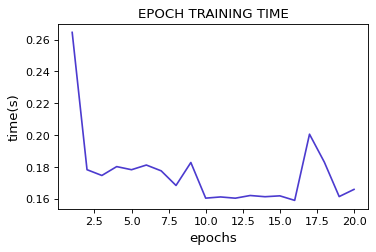

In [ ]:
epochs = np.arange(1, N_EPOCHS + 1)
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, history.epoch_train_time, color='#4C3BCF')
plt.title("EPOCH TRAINING TIME", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("time(s)", fontsize=12)
plt.show()

Visualizing the model training and validation losses.

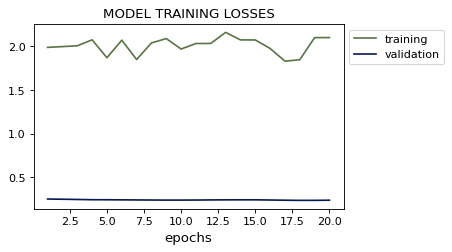

In [ ]:
epochs = np.arange(1, N_EPOCHS + 1)
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, history.train_losses, label="training", color="#597445")
plt.plot(epochs, history.val_losses, label="validation", color="#071952")
plt.title("MODEL TRAINING LOSSES", color="k", fontsize=12)
plt.legend(fontsize=10, bbox_to_anchor=(1, 1), loc='upper left')
plt.xlabel("epochs", fontsize=12)
plt.show()

Visualizing the model training and validation accuracies.

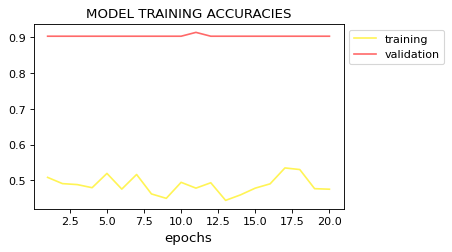

In [ ]:
epochs = np.arange(1, N_EPOCHS + 1)
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, history.train_acc, label="training", color="#FFF455")
plt.plot(epochs, history.val_acc, label="validation", color="#FF6969")
plt.title("MODEL TRAINING ACCURACIES", color="k", fontsize=12)
plt.legend(fontsize=10, bbox_to_anchor=(1, 1), loc='upper left')
plt.xlabel("epochs", fontsize=12)
plt.show()

### Evaluating the best model.
In the following code cell we are going to evaluate the best model using on the `test` data as follows:

In [ ]:
column_names = ["Set", "Loss", "Accuracy", "ETA (time)"]
mhcb_model.load_state_dict(torch.load(MODEL_NAME))
test_loss, test_acc = evaluate(mhcb_model, test_loader, criterion)
title = "Model Evaluation Summary"
data_rows = [["Test", f'{test_loss:.3f}', f'{test_acc * 100:.2f}%', ""]]

tabulate_data(column_names, data_rows, title)

Model Evaluation Summary
+------+-------+----------+------------+
| Set  |  Loss | Accuracy | ETA (time) |
+------+-------+----------+------------+
| Test | 0.286 |   92.33% |            |
+------+-------+----------+------------+


### Model Inference
In the following code cell we are going to make predictions with the best model. We will have the function called `inference_preprocess_text` which is a function that process the text for inference.

In [ ]:
def inference_preprocess_text(text, max_len=100, padding="pre"):
  assert padding=="pre" or padding=="post", "the padding can be either pre or post"
  text_holder = torch.zeros(max_len, dtype=torch.int32) # fixed size tensor of max_len with  = 0
  processed_text = torch.tensor(text_pipeline(text), dtype=torch.int32)
  pos = min(max_len, len(processed_text))
  if padding == "pre":
    text_holder[:pos] = processed_text[:pos]
  else:
    text_holder[-pos:] = processed_text[-pos:]
  text_list= text_holder.unsqueeze(dim=0)
  return text_list

### Predicting Tags
In the following code cell we are going to create a function that predicts the `tags` given a certain `pattern` called `predict_tags`.

In [ ]:
class Prediction:
  def __init__(self, pattern: str, tag: str, tagId: int, confidence: float):
    self.pattern = pattern
    self.tag = tag
    self.tagId = tagId
    self.confidence = confidence

  def __repr__(self) -> str:
    return f"<MHCB Preciction: {self.tag}>"

  def __str__(self) -> str:
    return f"<MHCB Preciction: {self.tag}>"

  def to_json(self):
    return {
        'pattern':  self.pattern,
        'tag':  self.tag,
        'tagId':  self.tagId,
        'confidence':  self.confidence,
    }

In [ ]:
def predict_tag(model, sentence, device):
  model.eval()
  with torch.no_grad():
    tensor = inference_preprocess_text(sentence).to(device)
    length = torch.tensor([len(t) for t in tensor])
    probabilities = torch.softmax(model(tensor, length).squeeze(0), dim=0)
    prediction = torch.argmax(probabilities)
    prediction = prediction.detach().cpu().item()
    tags = {v:k for k, v in labels_dict.items()}
    tag = tags[prediction]

    return Prediction(
        sentence.lower(), tag, int(prediction), float(round(probabilities[prediction].item(), 2))
    )

In [ ]:
predict_tag(mhcb_model, "nothing much", device)

<MHCB Preciction: neutral-response>

### Downloading the model.
We are going to download the model

In [ ]:
files.download(MODEL_NAME)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>